In [1]:
!pip install -U gensim

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

In [3]:
path = Path('F:/')
data_path = path/'Projects'
os.listdir(data_path)

['.ipynb_checkpoints',
 'Home_and_Kitchen.csv',
 'Home_and_Kitchen_model.ipynb',
 'Home_and_Kitchen_preprocessing.ipynb',
 'NLPvenv',
 'NLP_project',
 'spam_home_kitchen.csv',
 'spam_sports.csv',
 'spam_sports_balanced.csv',
 'spam_sports_test.csv',
 'test_spam_home_kitchen.csv',
 'text_home_kitchen.csv',
 'text_sports.csv',
 'text_sports_test.csv']

In [4]:
spam_data = pd.read_csv(data_path/'spam_sports.csv')
spam_data = spam_data.dropna()
test_data = pd.read_csv(data_path/'spam_sports_test.csv')
test_data = test_data.dropna()

In [5]:
spam_data.head()

,Processed Text,class
0,might use dirty rust real alice clip appear mi...,0.0
1,accurate shot like old school iron site remova...,1.0
2,great present niece love ride ride come assemb...,1.0
3,great watch nice seiko watch easy read day dat...,1.0
4,safe wad value price comfortable use wad boot ...,1.0


In [6]:
X_train = spam_data['Processed Text']
Y_train = spam_data['class']

In [7]:
X_test = test_data['Processed Text']
Y_test = test_data['class']

Word2Vec

In [8]:

words_in_sentences=[]
for i in tqdm(range(len(spam_data))):
    text = spam_data.iloc[i, 0]
    words_in_sentences.append(text.split())
words_in_sentences[0]

100%|█████████████████████████████████████████████████████████████████████████| 17543/17543 [00:00<00:00, 21643.90it/s]


['might',
 'use',
 'dirty',
 'rust',
 'real',
 'alice',
 'clip',
 'appear',
 'might',
 'use',
 'dirty',
 'rust',
 'likley',
 'brand',
 'new',
 'store',
 'correctly',
 'per',
 'package',
 'import',
 'vietnam',
 'work',
 'fine']

In [9]:
w = Word2Vec(sentences=words_in_sentences,vector_size = 600)
vocab=list(w.wv.key_to_index.keys())
vocab[:10]

['great', 'use', 'get', 'good', 'well', 'one', 'work', 'like', 'would', 'make']

In [10]:
#Average Word2Vec is a technique in which the average of word embeddings of all the words given in a sentence is used as the numerical vector for a given sentence.
def avg_w2vec(sentences):
    transformed=[]
    for sentence in tqdm(sentences):
        count=0
        vector=np.zeros(600)
        for word in sentence.split():
            if word in vocab:
                vector+=w.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
        else:
            print(sentence)
    return np.array(transformed)

In [11]:
x_train_transformed=avg_w2vec(X_train)
x_test_transformed=avg_w2vec(X_test)

100%|█████████████████████████████████████████████████████████████████████████████| 7521/7521 [00:07<00:00, 952.94it/s]


In [12]:
#Using K-Nearest Neighbors Algorithm to predict whether a given review is Spam or not
grid_params = { 'n_neighbors' : [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80],
               'metric' : ['manhattan']}
knn=KNeighborsClassifier()
clf = RandomizedSearchCV(knn, grid_params, random_state=0,n_jobs=-1,verbose=1)
clf.fit(x_train_transformed,Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'metric': ['manhattan'],
                                        'n_neighbors': [5, 10, 15, 20, 25, 30,
                                                        35, 40, 45, 50, 55, 60,
                                                        65, 70, 75, 80]},
                   random_state=0, verbose=1)

In [13]:
clf.best_params_

{'n_neighbors': 50, 'metric': 'manhattan'}

In [14]:
clf.best_score_

0.6423645111300377

In [15]:
clf.cv_results_

{'mean_fit_time': array([0.15591044, 0.16570249, 0.18569131, 0.19009237, 0.18709126,
        0.18509259, 0.19448571, 0.18829145, 0.19248772, 0.19528584]),
 'std_fit_time': array([0.00993538, 0.00684744, 0.00381308, 0.01409552, 0.01213253,
        0.01315886, 0.00699928, 0.01105058, 0.01108677, 0.01801905]),
 'mean_score_time': array([115.48748837, 113.39329696, 115.27001333, 113.10626016,
        116.1173233 , 114.17324619, 113.95637245, 116.21786442,
        111.81500893,  87.00234494]),
 'std_score_time': array([ 1.93521505,  2.19110116,  2.1236301 ,  1.97657578,  2.10750108,
         2.26316202,  2.29679149,  2.09801142,  0.73235795, 28.12650111]),
 'param_n_neighbors': masked_array(data=[10, 35, 45, 50, 70, 25, 15, 75, 55, 40],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_metric': masked_array(data=['manhattan', 'manhattan', 'manhattan', 'manhattan',
       

In [16]:
train_fpr,train_tpr,thresholds=roc_curve(Y_train,clf.predict_proba(x_train_transformed)[:,1])
test_fpr,test_tpr,thresholds=roc_curve(Y_test,clf.predict_proba(x_test_transformed)[:,1])

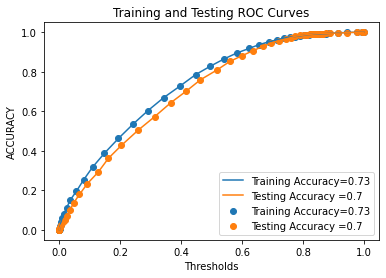

In [17]:

plt.plot(train_fpr,train_tpr,label="Training Accuracy="+str(round(auc(train_fpr, train_tpr),2)))
plt.plot(test_fpr,test_tpr,label="Testing Accuracy ="+str(round(auc(test_fpr, test_tpr),2)))
plt.scatter(train_fpr,train_tpr,label="Training Accuracy="+str(round(auc(train_fpr, train_tpr),2)))
plt.scatter(test_fpr,test_tpr,label="Testing Accuracy ="+str(round(auc(test_fpr, test_tpr),2)))
plt.legend()
plt.xlabel("Thresholds")
plt.ylabel("ACCURACY")
plt.title("Training and Testing ROC Curves")
plt.show()

In [18]:
clf_pred = clf.predict(x_test_transformed)
cff_train_pred= clf.predict(x_train_transformed)

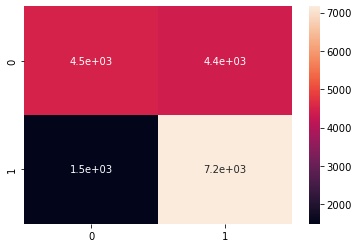

In [19]:
sns.heatmap(confusion_matrix(Y_train,cff_train_pred),annot=True)
plt.show()

In [20]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print('Accuracy score: ', format(accuracy_score(Y_train,cff_train_pred)))
print('Precision score: ', format(precision_score(Y_train,cff_train_pred)))
print('Recall score: ', format(recall_score(Y_train,cff_train_pred)))
print('F1 score: ', format(f1_score(Y_train,cff_train_pred)))

Accuracy score:  0.6639115316650516
Precision score:  0.6189735614307932
Recall score:  0.8282080924855492
F1 score:  0.7084651898734177


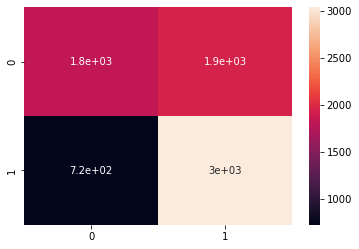

In [21]:
sns.heatmap(confusion_matrix(Y_test,clf_pred),annot=True)
plt.show()

In [22]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print('Accuracy score: ', format(accuracy_score(Y_test,clf_pred)))
print('Precision score: ', format(precision_score(Y_test,clf_pred)))
print('Recall score: ', format(recall_score(Y_test,clf_pred)))
print('F1 score: ', format(f1_score(Y_test,clf_pred)))

Accuracy score:  0.6455258609227497
Precision score:  0.6093153985143546
Recall score:  0.8082556591211718
F1 score:  0.6948260073260074


In [23]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

svc = SVC(kernel = 'sigmoid', gamma = 1.0)
svc.fit(x_train_transformed, Y_train)

Y_pred = svc.predict(x_train_transformed)
Y_test_pred = svc.predict(x_test_transformed)
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print('Accuracy score: ', format(accuracy_score(Y_pred,Y_train )))
print('Precision score: ', format(precision_score(Y_train,Y_pred)))
print('Recall score: ', format(recall_score(Y_train, Y_pred)))
print('F1 score: ', format(f1_score(Y_train, Y_pred)))

Accuracy score:  0.48572080031921566
Precision score:  0.3302919708029197
Recall score:  0.04184971098265896
F1 score:  0.07428688692797045


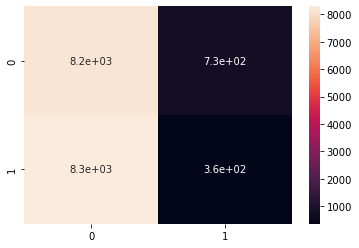

In [24]:
sns.heatmap(confusion_matrix(Y_train,Y_pred),annot=True)
plt.show()

In [25]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print('Accuracy score: ', format(accuracy_score(Y_test,Y_test_pred)))
print('Precision score: ', format(precision_score(Y_test,Y_test_pred)))
print('Recall score: ', format(recall_score(Y_test,Y_test_pred)))
print('F1 score: ', format(f1_score(Y_test,Y_test_pred)))

Accuracy score:  0.48145193458316715
Precision score:  0.346723044397463
Recall score:  0.04367509986684421
F1 score:  0.07757805108798486


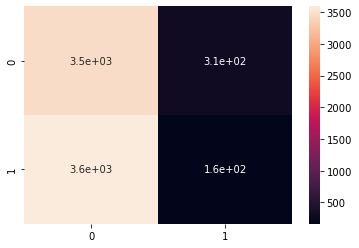

In [26]:
sns.heatmap(confusion_matrix(Y_test,Y_test_pred),annot=True)
plt.show()